In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Notebook 1: Introduction
This notebook serves to show how to implement a simple neural network model from scratch, and how to train and evaluate it. Only Numpy is used.

# The dataset (MNIST)

In this first step, we load and visualize the data set. We also have to preprocess it a bit.

### Loading the data

First, we load the data from the provided .csv-files. The csv-files consist of one row per datapoint, the first entry being the target class (digit) and the 784 (which equals 28x28) other entries being the (row-wise linearized) grayscale pixels of the respective image (values between 0 and 255).



In [2]:
import csv

# Train data
with open("sample_data/mnist_train_small.csv", newline='\n') as csvfile:
  csvfile = csv.reader(csvfile, delimiter=',')
  data = np.array([r for r in csvfile])
  data_train_x = data[:,1:].astype('float')
  data_train_y = data[:,0].astype('int')


# Test data
with open("sample_data/mnist_test.csv", newline='') as csvfile:
  csvfile = csv.reader(csvfile, delimiter=',')
  data = np.array([r for r in csvfile])
  data_test_x = data[:,1:].astype('float')
  data_test_y = data[:,0].astype('int')

### Inspecting the data

Now, we can inspect our data and check its shapes.

data_train_x.shape: (20000, 784)
data_train_y.shape: (20000,)
data_test_x.shape: (10000, 784)
data_test_y.shape: (10000,)


Label: 7


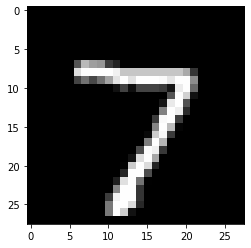

In [3]:
# Shape of the datasets:
print("data_train_x.shape:",data_train_x.shape)
print("data_train_y.shape:",data_train_y.shape)
print("data_test_x.shape:",data_test_x.shape)
print("data_test_y.shape:",data_test_y.shape)
print("\n")


# Picturing the first entry of the test dataset:
x0 = data_test_x[0]
y0 = data_test_y[0]
print("Label:",y0)


x0_reshaped = x0.reshape((28,28))
plt.imshow(x0_reshaped, cmap='gray')
plt.show()

### Preprocessing the data

For preprocessing, we divide each grayscale value by 255 and standardize the dataset. Also, we transform the target labels into one-hot encodings.

In [4]:
data_train_x /= 255
data_test_x /= 255

data_x = np.concatenate((data_train_x,data_test_x))
mean = np.mean(data_x)
std = np.std(data_x)

# standardization
data_train_x = (data_train_x-mean)/std
data_test_x = (data_test_x-mean)/std

data_train_y_one_hot = np.eye(10)[data_train_y]
data_test_y_one_hot = np.eye(10)[data_test_y]


# The model: a simple MLP

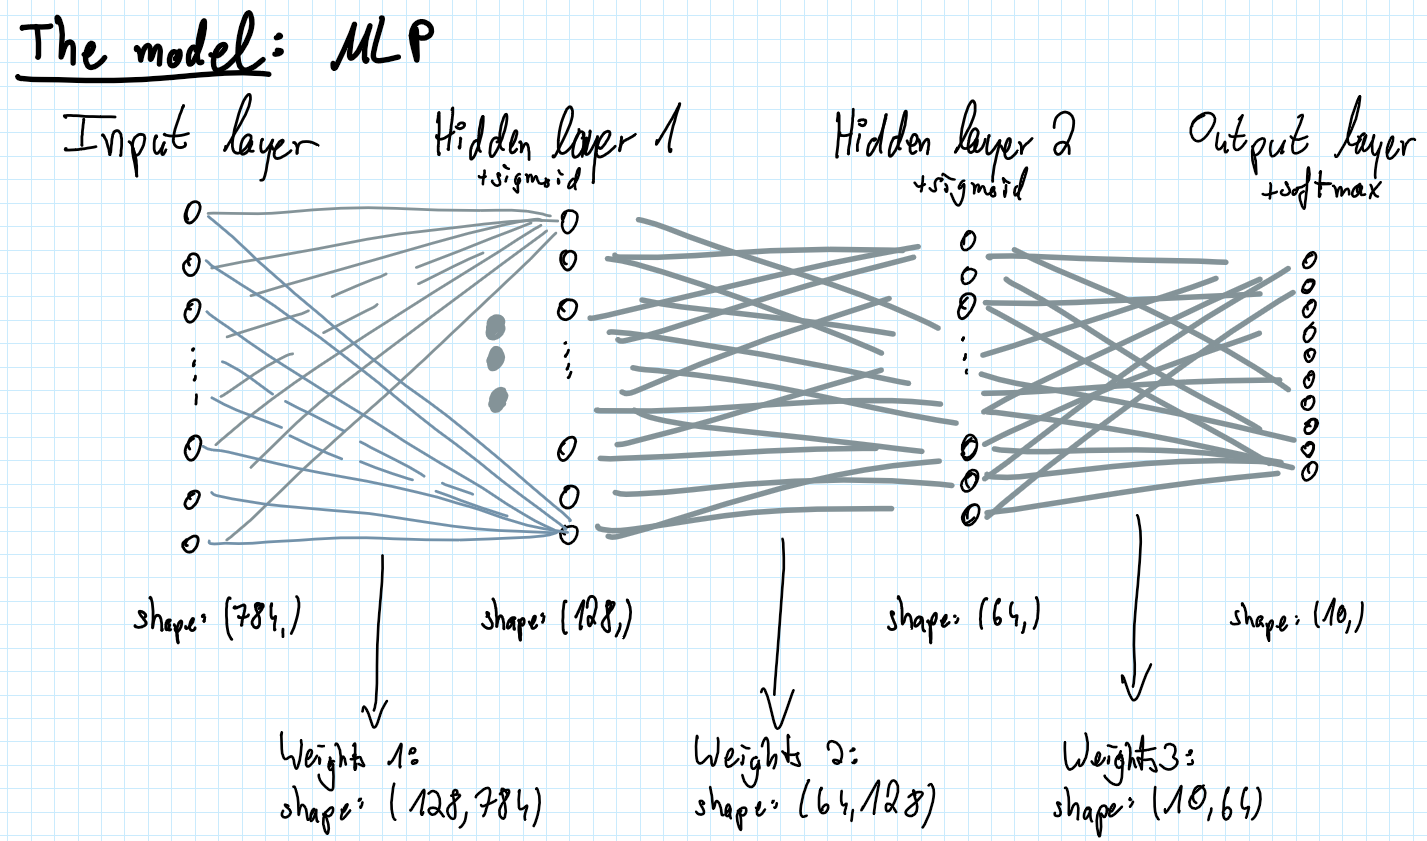

### The easiest parts first!

To start off, lets implement sigmoid and softmax.

In [5]:
def sigmoid(z): # input is an array
    return 1/(1 + np.exp(-z))

def softmax(z): # input is an array
    exps = np.exp(z - z.max())
    return exps / (np.sum(exps, axis=0))

**Softmax example:**

Input: [1, 2, 3, 4, 1, 2, 3]

Output: [0.024, 0.064, 0.175, 0.475, 0.024, 0.064, 0.175]





---





**Sigmoid plot:**
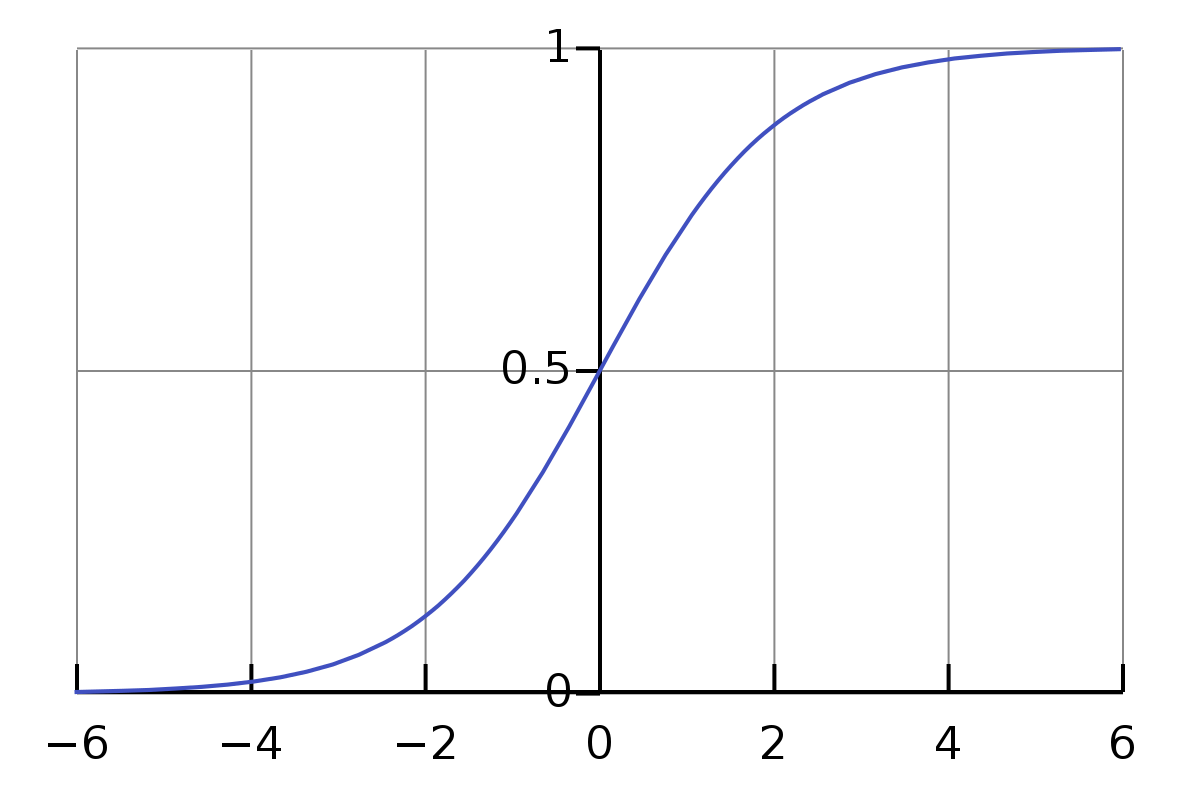

Source: Wikipedia

#### Beginning the model class

Now we should begin writing the model class. We will do this step by step and add the functions as we go, with explanations in-between.

In [6]:
class FFN():
  def __init__(self, sizes=[784, 128, 64, 10], epochs=10, l_rate=0.01):
    self.sizes = sizes
    self.epochs = epochs
    self.l_rate = l_rate

    self.params = self.initialize_parameters()
  
model = FFN(epochs=5)

### Setting up the network: Initialization

We must guarantee that the initial parameters (the weights) have some variation in them. Otherwise, the model could not begin with the training. For more details, see [this blog post.](https://towardsdatascience.com/neural-network-breaking-the-symmetry-e04f963395dd). It also explains the specific form of initialization we are using, called Xavier initialization.

In [7]:
def initialize_parameters(self):
  input_layer=self.sizes[0]
  hidden_1=self.sizes[1]
  hidden_2=self.sizes[2]
  output_layer=self.sizes[3]

  params = { # Xavier initialization
      'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
      'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
      'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
  }

  print("Initialized! Total parameters:", np.prod(params['W1'].shape)+np.prod(params['W2'].shape)+np.prod(params['W3'].shape))

  return params

FFN.initialize_parameters = initialize_parameters


### Implementing the forward pass:

Now, we have everything we need to implement a forward pass:

In [8]:
  def forward(self, x_train): 
        params = self.params

        # the first activations should just be the input sample
        params['A0'] = x_train # x_train is of shape (784,)

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = softmax(params['Z3'])

        return params['A3']

FFN.forward=forward


### Evaluating the model:

We can now also write some code to evaluate the accuracy of our model on some data:

In [9]:
def accuracy(self, data_x, data_y):
    predictions = []

    for x, y in zip(data_x, data_y):
        output = self.forward(x)
        pred = np.argmax(output)
        predictions.append(pred == y)
    return np.mean(predictions)

FFN.accuracy=accuracy

### Sanity check: performance of a random network

To test the code that we have so far, we can initialize our model with random weights, and compute the accuracy on the MNIST training dataset. Since we haven't trained it, we should expect an accuracy of somewhere around 10%, since there are 10 classes in our dataset. The concrete value depends on the initialization, which is random.

In [10]:
model = FFN()
accuracy = model.accuracy(data_train_x, data_train_y)
print("Accuracy = {:02f}%".format(accuracy*100))

Initialized! Total parameters: 109184
Accuracy = 10.095000%


### Backpropagation

Next, we should implement the function that allows us to compute the gradients of the loss w.r.t. the weights.
Before that, we have to derive and implement the derivative of sigmoid and softmax!

In [11]:
def sigmoid_derivative(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

def softmax_derivative(x): # See references for derivation
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

In [12]:
def backward(self, data_y, predictions):
    params = self.params
    change_w = {}

    # Calculate W3 update
    error = 2 * (predictions - data_y) * softmax_derivative(params['Z3'])
    change_w['W3'] = np.outer(error, params['A2']) # See https://numpy.org/doc/stable/reference/generated/numpy.outer.html

    # Calculate W2 update
    error = np.dot(params['W3'].T, error) * sigmoid_derivative(params['Z2'])
    change_w['W2'] = np.outer(error, params['A1'])

    # Calculate W1 update
    error = np.dot(params['W2'].T, error) * sigmoid_derivative(params['Z1'])
    change_w['W1'] = np.outer(error, params['A0'])

    return change_w

FFN.backward = backward


In [13]:
def update_network_parameters(self, changes_to_w):
  for key, value in changes_to_w.items():
    self.params[key] -= self.l_rate * value 
FFN.update_network_parameters = update_network_parameters

### Training loop

Finally, we can tie everything together by writing a training loop:



In [14]:
def train(self, data_x, data_y):
  for epoch in range(self.epochs):
      accuracy = self.accuracy(data_x, np.argmax(data_y,axis=1))
      print('Epoch: {:d}, Train accuracy = {:.2f}%'.format( epoch, accuracy*100))

      for x,y in zip(data_x, data_y):
          output = self.forward(x)
          changes_to_w = self.backward(y, output)
          self.update_network_parameters(changes_to_w)

FFN.train = train

### Executing the training:

Lets create a model object and train it for a bit, then evaluate its accuracy on the test set.


In [15]:
model = FFN(epochs=10, l_rate=0.01)
model.train(data_train_x, data_train_y_one_hot)

print()
accuracy = model.accuracy(data_test_x, data_test_y)
print("Test accuracy = {:.2f}%".format(accuracy*100))

Initialized! Total parameters: 109184
Epoch: 0, Train accuracy = 10.11%
Epoch: 1, Train accuracy = 82.97%
Epoch: 2, Train accuracy = 91.61%
Epoch: 3, Train accuracy = 93.36%
Epoch: 4, Train accuracy = 94.30%
Epoch: 5, Train accuracy = 94.92%
Epoch: 6, Train accuracy = 95.40%
Epoch: 7, Train accuracy = 95.84%
Epoch: 8, Train accuracy = 96.23%
Epoch: 9, Train accuracy = 96.47%

Test accuracy = 94.46%


# Doing the same in PyTorch

In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [17]:
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [18]:
class TorchFFN(nn.Module):
    def __init__(self,sizes=[784, 128, 64, 10]):
        super().__init__()

        fc1 = nn.Linear(sizes[0],sizes[1])
        fc2 = nn.Linear(sizes[1],sizes[2])
        fc3 = nn.Linear(sizes[2],sizes[3])
        self.layers = nn.Sequential(
                        fc1,
                        nn.Sigmoid(),
                        fc2,
                        nn.Sigmoid(),
                        fc3,
                        #nn.Softmax() is computed in loss
        )

    def forward(self, input):
      return self.layers(input)


In [19]:
model = TorchFFN()
epochs, lr = 10, 0.01
opt = torch.optim.SGD(model.parameters(), lr=lr)
objective = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=16, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=16, 
                                          shuffle=False)

In [20]:
test_acc = []
for epoch in range(epochs):
    correct = 0
    count = 0
    for i,(x, y) in enumerate(train_loader):
        x = x.reshape(x.shape[0],-1)
        outputs = model(x)
        _ , predicted = torch.max(outputs.data, 1)
        count += y.size(0)
        correct += (predicted == y).sum()

    acc = correct/count
    print("Epoch: %d, Train accuracy: %.2f" % (epoch, acc*100))
    test_acc.append(acc)

    for i,(x, y) in enumerate(train_loader):
        x = x.reshape(x.shape[0],-1)
        opt.zero_grad()
        output = model(x)
        loss = objective(output,y)
        loss.backward()
        opt.step()


correct = 0
count = 0
for i,(x, y) in enumerate(test_loader):
    x = x.reshape(x.shape[0],-1)
    outputs = model(x)
    _ , predicted = torch.max(outputs.data, 1)
    count += y.size(0)
    correct += (predicted == y).sum()

acc = correct/count
print("Test accuracy = %.2f" % (acc*100))

Epoch: 0, Train accuracy: 11.19
Epoch: 1, Train accuracy: 90.49
Epoch: 2, Train accuracy: 92.75
Epoch: 3, Train accuracy: 94.41
Epoch: 4, Train accuracy: 95.33
Epoch: 5, Train accuracy: 96.09
Epoch: 6, Train accuracy: 96.64
Epoch: 7, Train accuracy: 97.12
Epoch: 8, Train accuracy: 97.10
Epoch: 9, Train accuracy: 97.68
Test accuracy = 97.06


# References and Sources

*   Backpropagation intuition: https://cs231n.github.io/optimization-2/#grad

*   Softmax derivative: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/ and https://deepnotes.io/softmax-crossentropy

*   Initialization: https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
*   Different loss options: https://gombru.github.io/2018/05/23/cross_entropy_loss/
*   Code partially based on: https://mlfromscratch.com/neural-network-tutorial/#/
